In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from torchdiffeq import odeint_adjoint as odeint
from torch import Tensor

import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

from models.models import MLP
from flow_matching.models import DiffusionFM, COTFM
from utils.datasets import get_data, create_dataloader
from flow_matching.samplers import Sampler2D

In [2]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"
torch.device(device)

device(type='cuda', index=1)

In [131]:
import numpy as np
from torchdiffeq import odeint
from matplotlib import pyplot as plt
import torch
from torch import nn
from models.models import ModelWrapper

from torchdiffeq import odeint_event

class Sampler2D:
    def __init__(self, model: nn.Module, x_0, time_steps=10, fm_method="default",ode_method="dopri5", device=None):
        """
        Initializes the Sampler2D class and computes the solution.

        Parameters:
        - model (nn.Module): The model representing the dynamics.
        - x_0 (torch.Tensor): Initial state, shape [samples, dimensions].
        - device (torch.device or str): The device to run the model and computations on (default is None, which uses the CPU).
        - time_steps (int): Number of time steps to solve for.
        - ode_method (str): ODE solver ode_method (default is 'dopri5').
        """
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = ModelWrapper(model, count_nfe=True).to(self.device) 
        self.x_0 = x_0.to(self.device)
        self.time_steps = time_steps
        self.ode_method = ode_method
        self.fm_method = fm_method

        # Compute the solution during initialization
        self.solution = self.compute_solution(self.time_steps)

    def compute_solution(self, time_steps = 10):
        """
        Computes the solution of the dynamics using the given model.
        """
        if self.fm_method == "diffusion":
            t = torch.linspace(0, 1-1e-5, time_steps, device=self.device)
        else:
            t = torch.linspace(0, 1, time_steps, device=self.device)
        with torch.no_grad():
            solution = odeint(self.model, self.x_0, t, method=self.ode_method)
        return solution
    
    def compute_solution_from_t_to_t1(self, t, t1):
        """
        Computes the solution of the dynamics using the given model from t to t1.
        """
        assert t < t1, "t must be less than t1"
        if self.fm_method == "diffusion":
            assert t1 <= 1-1e-5, "t1 must be less than or equal to 1-1e-5"
        else:
            assert t1 <= 1, "t1 must be less than or equal to 1"
        assert t >= 0, "t must be greater than or equal to 0"
        
        t = torch.Tensor([t,t1]).to(self.device)
        with torch.no_grad():
            # atol=1e-5, rtol=1e-5 as in Lipman et al. 2023
            solution = odeint(self.model, self.x_0, t, method=self.ode_method, rtol=1e-5,  atol=1e-5)
        return solution

    def plot_sample(self, title="Sample from target distribution", figsize=(8, 6), point_size=15, alpha=0.7, color='blue'):
        """
        Plots a 2D scatter plot for the final time step of the solution.

        Parameters:
        - title (str): Title of the plot.
        - figsize (tuple): Size of the figure (width, height).
        - point_size (float): Size of the scatter points.
        - alpha (float): Transparency of the scatter points.
        - color (str or list): Color of the scatter points.
        """
        # Extract the last time step and dimensions
        x = self.solution[-1, :, 0].detach().cpu().numpy()
        y = self.solution[-1, :, 1].detach().cpu().numpy()

        # Create the plot
        plt.figure(figsize=figsize)
        plt.scatter(x, y, s=point_size, alpha=alpha, color=color)
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.title(title)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.gca().set_aspect('equal', adjustable='box')  # Ensure equal aspect ratio for axes
        plt.tight_layout()
        plt.show()

        
    def plot_trajectories(self, n=2000):
        """Plot trajectories of some selected samples."""
        solution_traj = self.compute_solution(time_steps=2000)
        solution_traj_np = solution_traj.detach().cpu().numpy()
        plt.figure(figsize=(6, 6))
        plt.scatter(solution_traj_np[0, :n, 0], solution_traj_np[0, :n, 1], s=4, alpha=0.8, c="black")
        plt.plot(solution_traj_np[:, :n, 0], solution_traj_np[:, :n, 1], linestyle="--", color="black", alpha=1, linewidth=0.3)
        plt.scatter(solution_traj_np[-1, :, 0], solution_traj_np[-1, :, 1], s=10, alpha=1, c="navy")
        plt.legend(["x0 ~ p", "Path", "x1 ~ q"])
        plt.xticks([])
        plt.yticks([])
        plt.show()
        

    def compute_solution_nfe_target(self, nfe_target=4, figsize=(16, 8), point_size=10, alpha=0.7, cmap='viridis'):
        """
        Computes the solution of the dynamics using the given model until the NFE target is reached.
        """
        self.model.reset_nfe()

        # Define an event function based on NFE
        def event_fn(t, y):
            # Stop when the NFE counter reaches the limit
            return torch.tensor([self.model.nfe - nfe_target], device=self.device)
        
        t = torch.Tensor(1).to(self.device)
        # Solve ODE with event detection
        with torch.no_grad():
            solution = odeint_event(
                self.model,
                self.x_0,
                t,
                event_fn=event_fn,
                reverse_time=False,
                odeint_interface=odeint,
                method=self.ode_method, 
                rtol=1e-5,
                atol=1e-5
            )

        return solution

    def compute_solution_time_target(self, time_target=0.5, figsize=(16, 8), point_size=10, alpha=0.7, cmap='viridis'):
        """
        Computes the solution of the dynamics using the given model until the NFE target is reached.
        """
        def event_fn(t, y):
            # Stop when time reaches the target
            return torch.tensor([time_target-t], device=self.device)
        
        t = torch.Tensor(1).to(self.device)
        # Solve ODE with event detection
        with torch.no_grad():
            solution = odeint_event(
                self.model,
                self.x_0,
                t,
                event_fn=event_fn,
                reverse_time=False,
                odeint_interface=odeint,
                method=self.ode_method, 
                rtol=1e-5,
                atol=1e-5
            )

        return solution
    
    def plot_flow_nfe_targets(self, nfe_targets, figsize=(16, 8), point_size=10, alpha=0.7, cmap='viridis', title="", title_y=0.75):
        """
        Plots a series of subplots showing the distribution of samples at each NFE target.

        Parameters:
        - nfe_targets (list): List of NFE targets to reach.
        - figsize (tuple): Size of the overall figure (width, height).
        - point_size (float): Size of the scatter points.
        - alpha (float): Transparency of the scatter points.
        - cmap (str): Colormap for the scatter points.
        """
        solutions = []
        times = []
        n_nfe_targets = len(nfe_targets)
        
        for nfe_target in nfe_targets:
            solution = self.compute_solution_nfe_target(nfe_target)
            solutions.append(solution[1][-1])
            times.append(solution[0])

        solutions_array = torch.stack(solutions).detach().cpu().numpy()
        times_array = torch.stack(times).detach().cpu().numpy()
    

        x_values = solutions_array[:, :, 0]
        y_values = solutions_array[:, :, 1]

        # Create subplots
        fig, axes = plt.subplots(1, n_nfe_targets, figsize=figsize, sharex=True, sharey=True)
        fig.suptitle(title, y=title_y, fontsize=16)
        # If there is only one subplot, axes will be a single Axes object
        if n_nfe_targets == 1:
            axes = [axes]

        for i in range(n_nfe_targets):
            ax = axes[i]
            sc = ax.scatter(
                x_values[i], 
                y_values[i],
                s=point_size,
                alpha=alpha,
                c=[i / (n_nfe_targets - (1-1e-5))] * len(x_values[i]),
                cmap=cmap
            )
            ax.set_title(f"t = {times_array[i]:.2f} NFE = {nfe_targets[i]}")
            ax.grid(True, linestyle='--', alpha=0.6)
            ax.set_aspect('equal', adjustable='box')    

        plt.tight_layout()
        plt.show()

    def plot_flow_time_targets(self, time_targets, figsize=(16, 8), point_size=10, alpha=0.7, cmap='viridis', title="", title_y=0.75):
        """
        Plots a series of subplots showing the distribution of samples at each NFE target.

        Parameters:
        - nfe_targets (list): List of NFE targets to reach.
        - figsize (tuple): Size of the overall figure (width, height).
        - point_size (float): Size of the scatter points.
        - alpha (float): Transparency of the scatter points.
        - cmap (str): Colormap for the scatter points.
        """
        solutions = []
        times = []
        n_time_targets = len(time_targets)
        
        for t_target in time_targets:
            solution = self.compute_solution_time_target(t_target)
            solutions.append(solution[1][-1])
            times.append(solution[0])

        solutions_array = torch.stack(solutions).detach().cpu().numpy()
        times_array = torch.stack(times).detach().cpu().numpy()

        x_values = solutions_array[:, :, 0]
        y_values = solutions_array[:, :, 1]

        # Create subplots
        fig, axes = plt.subplots(1, n_time_targets, figsize=figsize, sharex=True, sharey=True)
        fig.suptitle(title, y=title_y, fontsize=16)
        # If there is only one subplot, axes will be a single Axes object
        if n_time_targets == 1:
            axes = [axes]

        for i in range(n_time_targets):
            ax = axes[i]
            sc = ax.scatter(
                x_values[i], 
                y_values[i],
                s=point_size,
                alpha=alpha,
                c=[i / (n_time_targets - (1-1e-5))] * len(x_values[i]),
                cmap=cmap
            )
            ax.set_title(f"t = {times_array[i]:.2f}")
            ax.grid(True, linestyle='--', alpha=0.6)
            ax.set_aspect('equal', adjustable='box')    

        plt.tight_layout()
        plt.show()
    
    def plot_flow(self, time_steps, plot_nfe=True, figsize=(16, 8), point_size=10, alpha=0.7, cmap='viridis', title=""):
        """
        Plots a series of subplots showing the distribution of samples at each time step.

        Parameters:
        - figsize (tuple): Size of the overall figure (width, height).
        - point_size (float): Size of the scatter points.
        - alpha (float): Transparency of the scatter points.
        - cmap (str): Colormap for the scatter points.
        """
        nfe_results = [] 
        solutions = []
        if self.fm_method == "diffusion":
            nfe_times = torch.linspace(0, 1-1e-5, time_steps, device=self.device)
        else:
            nfe_times = torch.linspace(0, 1, time_steps, device=self.device)
        
        for i in nfe_times[1:]:
            self.model.nfe = 0
            solutions.append(self.compute_solution_from_t_to_t1(0, i)[-1])
            nfe_results.append(self.model.nfe)

        nfe_results_array = np.array(nfe_results)
        solutions_array = torch.stack(solutions).detach().cpu().numpy()
        
        x_values = solutions_array[:, :, 0]
        y_values = solutions_array[:, :, 1]
        time_steps = len(nfe_results_array)

        # Create subplots
        fig, axes = plt.subplots(1, time_steps, figsize=figsize, sharex=True, sharey=True)
        fig.suptitle(title, y=0.7, fontsize=16)

        for i in range(time_steps):
            ax = axes[i]
            sc = ax.scatter(
                x_values[i], 
                y_values[i],
                s=point_size,
                alpha=alpha,
                c=[i / (time_steps - 1)] * len(x_values[i]),
                cmap=cmap
            )
            if plot_nfe:
                ax.set_title(f"t = {(nfe_times[i+1]):.2f} - NFE: {nfe_results_array[i]}")
            else:
                ax.set_title(f"t = {(nfe_times[i+1]):.2f}")
            ax.grid(True, linestyle='--', alpha=0.6)
            ax.set_aspect('equal', adjustable='box')    
        
        plt.tight_layout()
        plt.show()

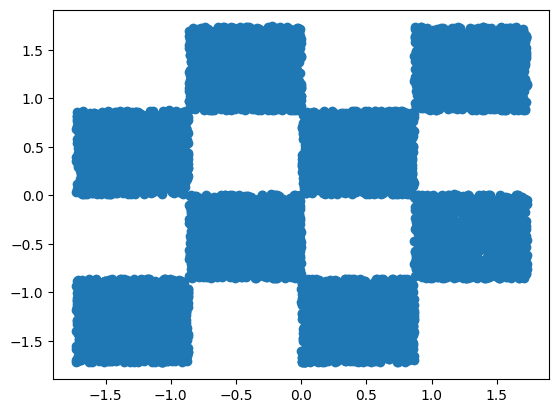

In [80]:
n_points = 10_000
DATASET = "checkers"
data = get_data(DATASET, n_points)

%matplotlib inline
plt.scatter(data[:, 0], data[:, 1])
plt.show()

batch_size = 2064
dataloader = create_dataloader(data, batch_size=batch_size)

In [19]:
model_diff=MLP(h=512).to(device)
fm = DiffusionFM() 
sigma_min = 0
optimizer=torch.optim.Adam(model_diff.parameters())
n_epochs=5000

for _ in tqdm(range(n_epochs)):  
    for batch in dataloader:
        x_1 = batch[0].to(device)
        
        loss = fm.loss(model_diff, x_1)
        
        optimizer.zero_grad()    
        loss.backward()    
        optimizer.step()     

100%|██████████| 5000/5000 [03:50<00:00, 21.67it/s]


In [28]:
model_ot=MLP(h=512).to(device)
fm = COTFM() 
sigma_min = 0
optimizer=torch.optim.Adam(model_ot.parameters())
n_epochs=5000

for _ in tqdm(range(n_epochs)):  
    for batch in dataloader:
        x_1 = batch[0].to(device)
        
        loss = fm.loss(model_ot, x_1)
        
        optimizer.zero_grad()    
        loss.backward()    
        optimizer.step()     

100%|██████████| 5000/5000 [03:39<00:00, 22.83it/s]


In [136]:
x_0 = torch.randn((10000,2), device=device)
sampler_ot = Sampler2D(model_ot, x_0, time_steps=10, fm_method="default", device=device)
sampler_diff = Sampler2D(model_diff, x_0, time_steps=10, fm_method="diffusion", device=device)

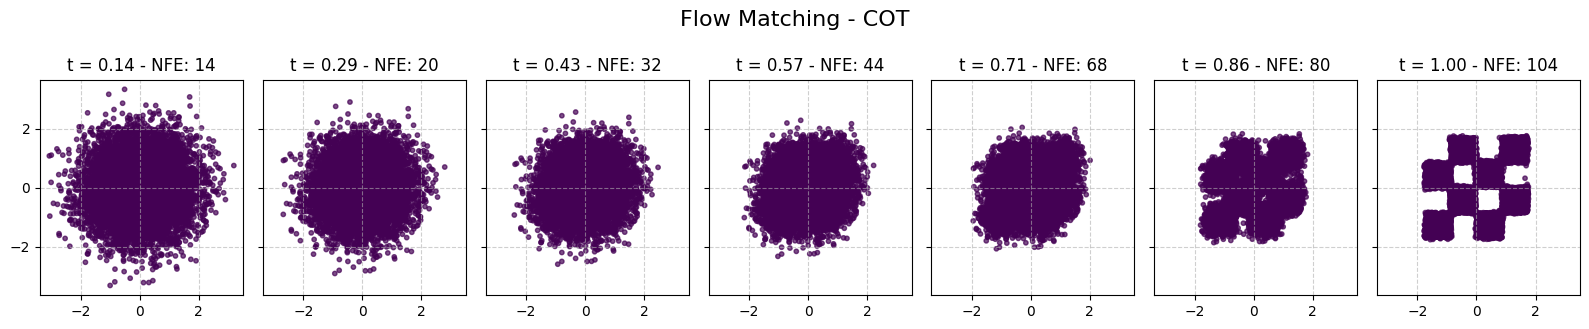

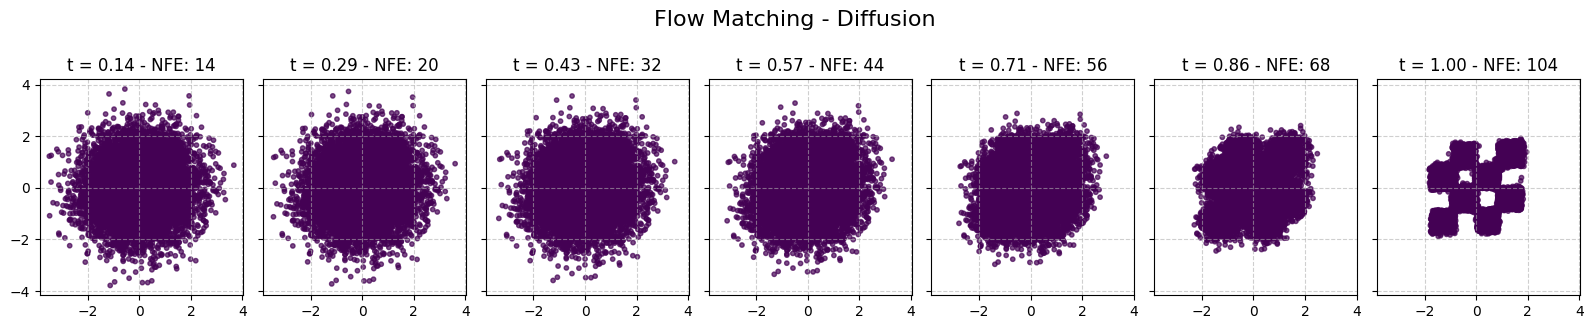

In [137]:
sampler_ot.plot_flow(8, plot_nfe=True, title="Flow Matching - COT")
sampler_diff.plot_flow(8, plot_nfe=True, title="Flow Matching - Diffusion")  

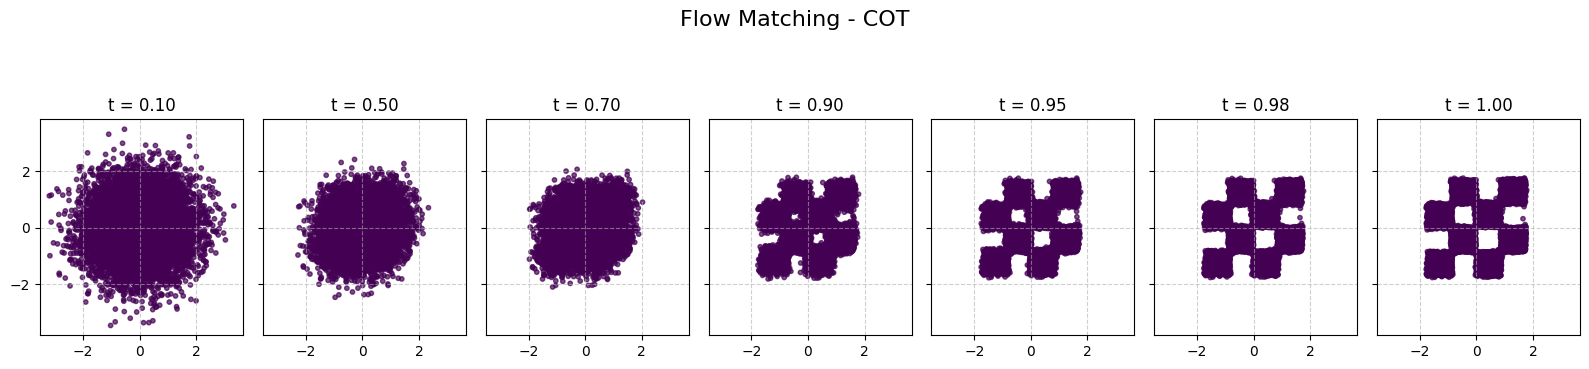

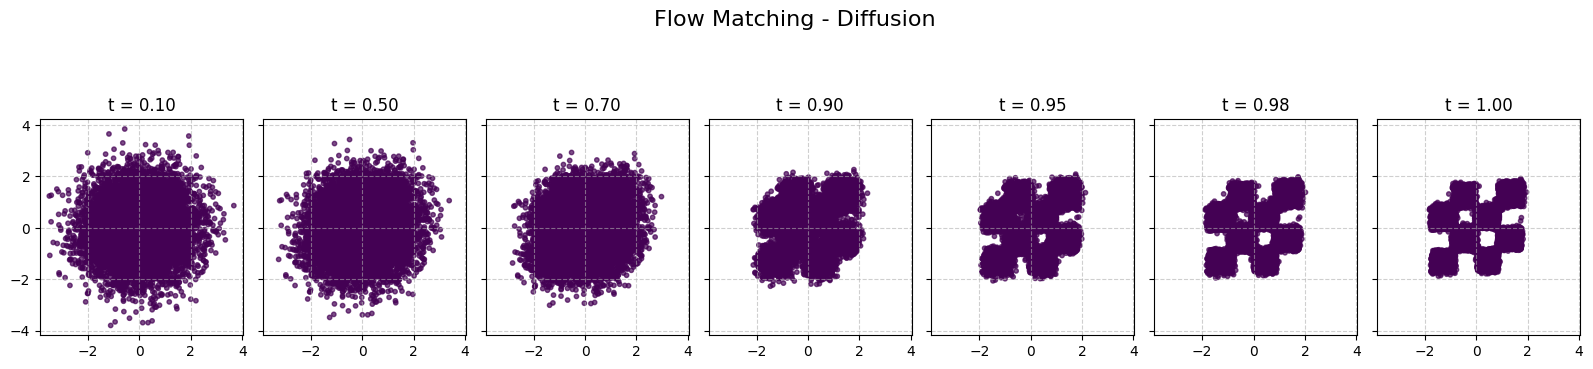

In [138]:
sampler_ot.plot_flow_time_targets([0.1, 0.5, 0.7, 0.9, 0.95, 0.98, 1], title="Flow Matching - COT", title_y=0.75)
sampler_diff.plot_flow_time_targets([0.1, 0.5, 0.7, 0.9, 0.95, 0.98, 1-1e-5], title="Flow Matching - Diffusion", title_y=0.75)

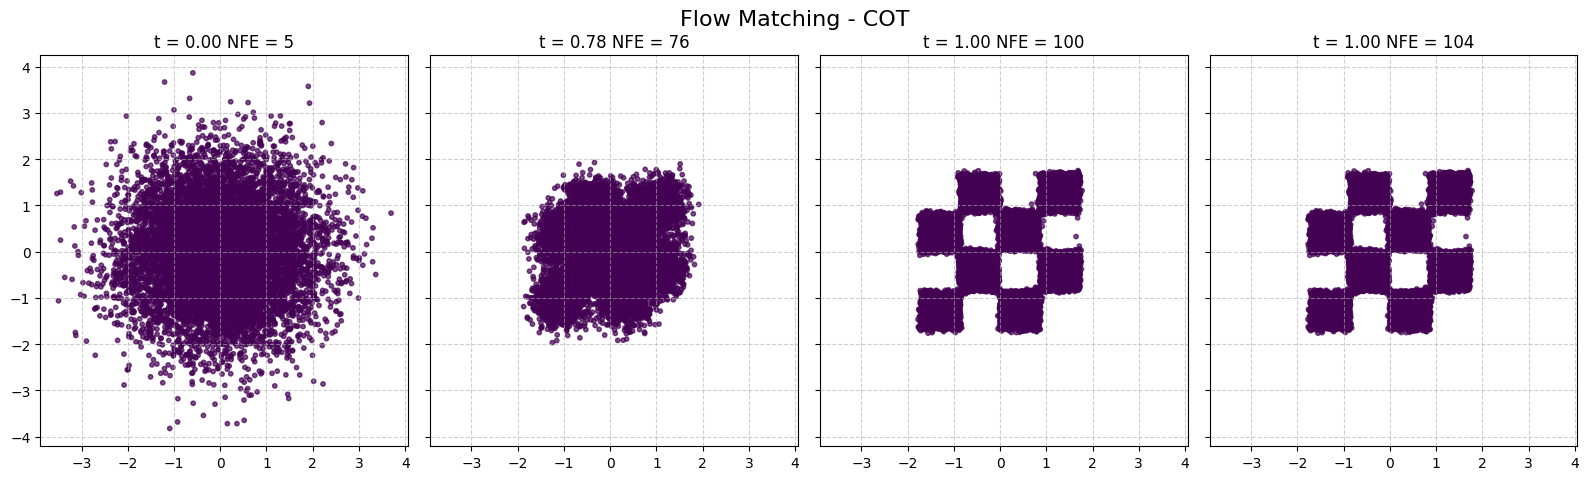

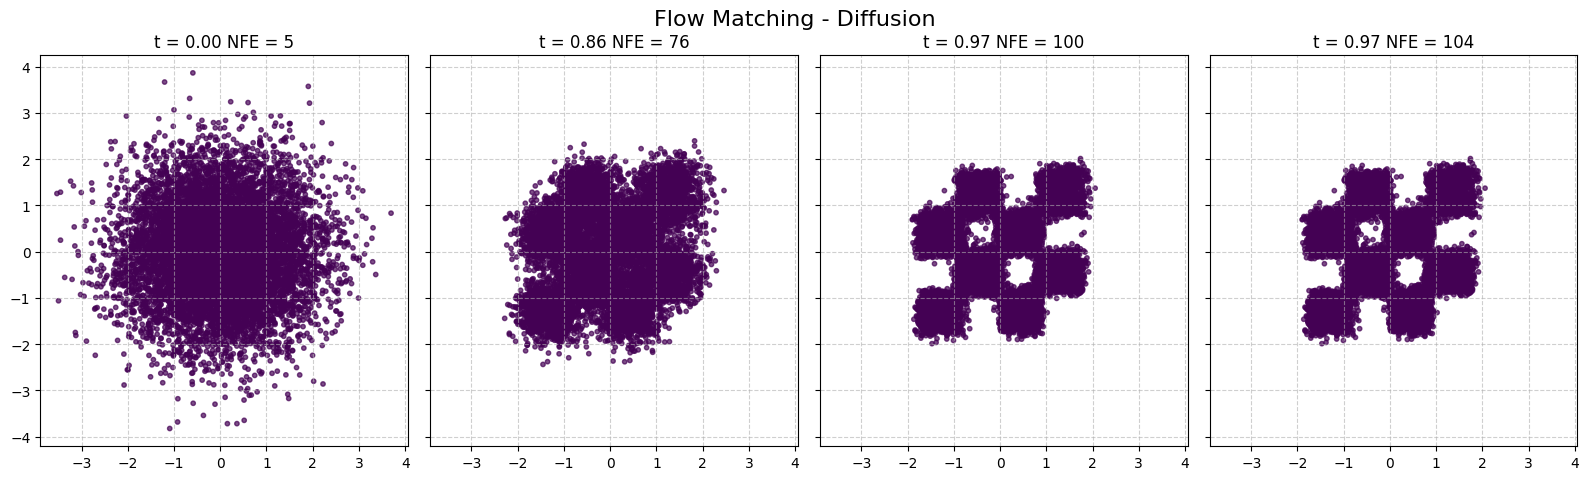

In [139]:
nfe_targets = [5, 76, 100, 104]
sampler_ot.plot_flow_nfe_targets(nfe_targets, title="Flow Matching - COT", title_y="0.78")
sampler_diff.plot_flow_nfe_targets(nfe_targets, title="Flow Matching - Diffusion", title_y="0.78")

In [18]:
n_epochs=5000

model=MLP(h=512).to(device) 
#model.apply(init_weights)
fm_type = DiffusionFM() 
optimizer=torch.optim.AdamW(model.parameters())
loss_fn=nn.MSELoss()


for i in tqdm(range(n_epochs)):
    for batch in dataloader:
        optimizer.zero_grad()
        
        x_1 = batch[0]  
        x_0 = torch.randn_like(x_1,dtype=torch.float32, device=device)    
        t = torch.rand(len(x_1), 1, dtype=torch.float32, device=device) * (1 - 1e-5)
        
        dx_t = fm_type.compute_dx_t(x_0, x_1, t)
        x_t = fm_type.compute_x_t(x_0, x_1, t) 
        
        v_pred = model(x_t, t)    
        loss = loss_fn(v_pred ,dx_t)
        
        loss.backward()
        
        optimizer.step()

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 0, Loss: 3953.6631
Epoch 0, Loss: 2399.8916
Epoch 0, Loss: 165.9310
Epoch 0, Loss: 159.6455
Epoch 0, Loss: 25715.9102
Epoch 0, Loss: 184.5116
Epoch 0, Loss: 226.5820
Epoch 0, Loss: 370.3814
Epoch 0, Loss: 1256.8643
Epoch 0, Loss: 262.9249
Epoch 0, Loss: 339.5604
Epoch 0, Loss: 367.1455
Epoch 0, Loss: 131.5199
Epoch 0, Loss: 1450.7980
Epoch 0, Loss: 56.5208
Epoch 0, Loss: 166.3844
Epoch 0, Loss: 44.6969
Epoch 0, Loss: 2545.9426
Epoch 0, Loss: 354.6656
Epoch 0, Loss: 97.4763
Epoch 0, Loss: 1881.3384
Epoch 0, Loss: 90.3630
Epoch 0, Loss: 506.0331
Epoch 0, Loss: 51.5455
Epoch 0, Loss: 161.5276
Epoch 0, Loss: 293.5547
Epoch 0, Loss: 757.3763
Epoch 0, Loss: 2997.6523
Epoch 0, Loss: 7589.6450
Epoch 0, Loss: 233.5791
Epoch 0, Loss: 132.7508
Epoch 0, Loss: 285.5215
Epoch 0, Loss: 68.2465
Epoch 0, Loss: 22.3917
Epoch 0, Loss: 102447.9062
Epoch 0, Loss: 125.7736
Epoch 0, Loss: 1884.0105
Epoch 0, Loss: 75.2361
Epoch 0, Loss: 484.6364
Epoch 0, Loss: 96.0348
Epoch 0, Loss: 3490.4160
Epoch 0, L

  0%|          | 1/5000 [00:01<1:30:30,  1.09s/it]

Epoch 0, Loss: 230.6120
Epoch 0, Loss: 129.7360
Epoch 0, Loss: 220.2950
Epoch 0, Loss: 148.3685
Epoch 0, Loss: 201.2083
Epoch 0, Loss: 4290.7510
Epoch 0, Loss: 1520.2361
Epoch 0, Loss: 176.4823
Epoch 0, Loss: 236.5077
Epoch 0, Loss: 5329.3857
Epoch 0, Loss: 238.9158
Epoch 0, Loss: 133.2654
Epoch 0, Loss: 5377.6328


  0%|          | 14/5000 [00:19<1:56:06,  1.40s/it]


KeyboardInterrupt: 

In [9]:
x_0 = torch.randn((256,2), dtype=torch.float32, device=device)
sampler = Sampler2D(model, x_0, time_steps=6, fm_method="diffusion", ode_method="dopri5", device=device)
sampler.plot_flow()
sampler.plot_trajectories()
sampler.plot_sample()

NameError: name 'Sampler2D' is not defined

In [ ]:
n_epochs=20000
lr = 1e-3

model=SimpleNN().to(device)
fm_type = COTFM() 
optimizer=torch.optim.AdamW(model.parameters())
loss_fn=nn.MSELoss()


for i in tqdm(range(n_epochs)):
    
    optimizer.zero_grad()
    
    x_1 = torch.tensor(make_moons(256)[0], dtype=torch.float32, device=device)
    
    x_0 = torch.randn_like(x_1,dtype=torch.float32, device=device)
    
    t = torch.rand(len(x_1), 1, dtype=torch.float32, device=device)
    
    dx_t = fm_type.compute_dx_t(x_0, x_1, 0.)
    x_t = fm_type.compute_x_t(x_0, x_1,0., t) 
    
    v_pred = model(x_t, t)
    
    loss = loss_fn(v_pred ,dx_t)
    
    loss.backward()
    
    optimizer.step()
    
    if i % 1000 == 0:
        print(f"Epoch {i}, Loss: {loss.item():.4f}")

In [ ]:
x_0 = torch.randn_like(x_1, dtype=torch.float32, device=device)
sampler = Sampler2D(model, x_0, time_steps=6, method="dopri5", device=device)
sampler.plot_flow()
sampler.plot_trajectories()
sampler.plot_sample()